In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [ ]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.06MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.28MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
len(train_data),len(test_data)

(60000, 10000)

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

torch.Size([1, 28, 28])


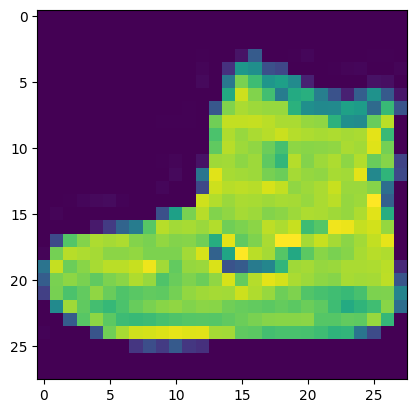

In [ ]:
import matplotlib.pyplot as plt
image,label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze())

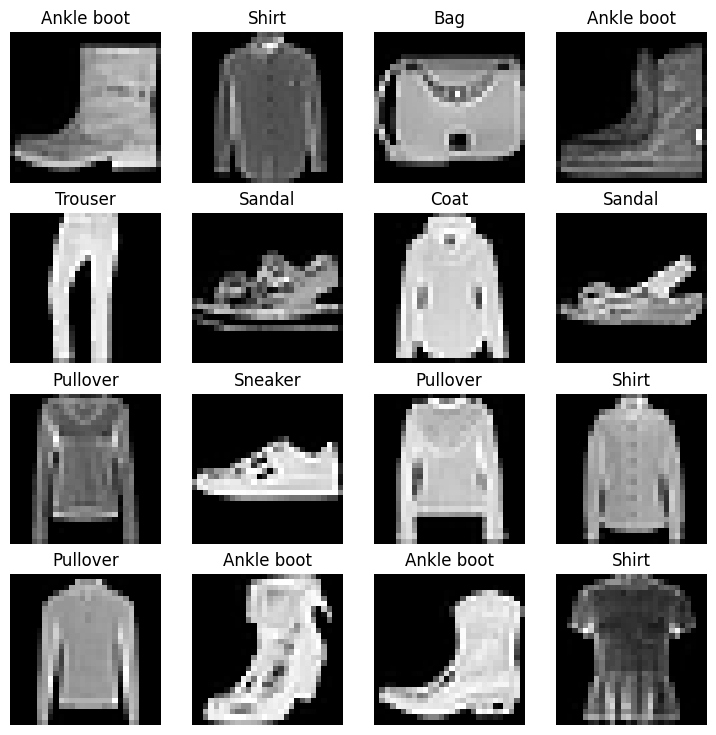

In [ ]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size = [1]).item()
    img,label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap = "gray")
    plt.title(class_names[label])
    plt.axis(False)

In [ ]:
train_data,test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = BATCH_SIZE,
    shuffle= False
)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ca2c4b33f40>,
 <torch.utils.data.dataloader.DataLoader at 0x7ca2c4b33880>)

In [ ]:
train_features_batch,train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

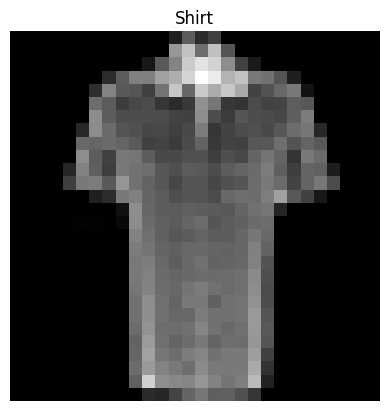

In [ ]:
torch.manual_seed(42)
random_idx = torch.randint(0,len(train_features_batch),size = [1]).item()
img,label = train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap = "gray")
plt.title(class_names[label])
plt.axis(False)

In [ ]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)
output.shape

torch.Size([1, 784])

In [ ]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape,hidden_units),
            nn.Linear(hidden_units,output_shape)
        )
    def forward(self,x):
        return self.layer_stack(x)


In [ ]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(
    input_shape = 784,
    hidden_units = 10,
    output_shape = len(class_names)
).to("cpu")
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py","wb") as f:
        f.write(request.content)


In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params = model_0.parameters(),lr = 0.01)


In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_cpu = timer()
epochs = 4
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_loss = 0
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred,y)
        train_loss +=loss
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader)
    test_loss,test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X_test,y_test in test_dataloader:
            test_pred = model_0(X_test)
            test_loss += loss_fn(test_pred,y_test)
            test_acc += accuracy_fn(y_true = y_test,y_pred = test_pred.argmax(dim = 1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    print(f"\nTrain loss {train_loss:.4f}| Test_loss {test_loss:.4f}| test_acc {test_acc:.4f}")
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,end = train_time_end_on_cpu,device = 'cpu')


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 0
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss 0.9096| Test_loss 0.6290| test_acc 78.6342
Epoch: 1
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss 0.5573| Test_loss 0.5441| test_acc 81.1302
Epoch: 2
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss 0.5027| Test_loss 0.5137| test_acc 81.9988
Epoch: 3
---------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss 0.4765| Test_loss 0.4944| test_acc 82.7875
Train time on cpu: 42.864 seconds


In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader,
               loss_fn,
               accuracy_fn):
    loss,acc = 0,0
    model.eval()
    model.to(device)
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred,y)
            acc += accuracy_fn(y_true = y,y_pred = y_pred.argmax(dim = 1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}
model_0_results = eval_model(model = model_0,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4944238066673279,
 'model_acc': 82.78753993610223}

In [ ]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape,hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,output_shape),
            nn.ReLU()
        )
    def forward(self,x):
        return self.layer_stack(x)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape = 784,hidden_units = 10,output_shape = len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [ ]:
!nvidia-smi

Sat Nov 23 12:50:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              27W /  70W |    151MiB / 15360MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params = model_1.parameters(),lr = 0.1)

In [ ]:
from helper_functions import accuracy_fn

In [ ]:
def train_step(model,
               data_loader,
               loss_fn,
               optimiser,
               accuracy_fn,
               device):
    train_loss = 0
    train_acc = 0
    model.train()
    for batch, (X,y) in enumerate(data_loader):
        X,y = X.to(device),y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred,y)
        train_loss +=loss
        train_acc += accuracy_fn(y_true = y,y_pred = y_pred.argmax(dim = 1))
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f}| Train acc: {train_acc:.2f}")

In [ ]:
def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn,
              device):
    test_loss,test_acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X,y = X.to(device),y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred,y)
            test_acc += accuracy_fn(y,test_pred.argmax(dim = 1))
        test_loss/= len(data_loader)
        test_acc/= len(data_loader)
    print(f"Test loss {test_loss:.5f}| Test acc {test_acc:.2f}")


In [ ]:
torch.manual_seed(42)
from timeit import default_timer as timer
time_train_on_gpu = timer()
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model = model_1,
               data_loader = train_dataloader,
               loss_fn = loss_fn,
               optimiser = optimiser,
               accuracy_fn = accuracy_fn,
               device = device)
    test_step(model = model_1,
              data_loader = test_dataloader,
              loss_fn = loss_fn,
              accuracy_fn = accuracy_fn,
              device = device)
time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start = time_train_on_gpu,end = time_end_on_gpu,device = device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199| Train acc: 61.34
Test loss 0.95636| Test acc 65.00
Epoch: 1
---------
Train loss: 0.78101| Train acc: 71.93
Test loss 0.72227| Test acc 73.91
Epoch: 2
---------
Train loss: 0.67027| Train acc: 75.94
Test loss 0.68500| Test acc 75.02
Train time on cuda: 37.686 seconds


In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4944238066673279,
 'model_acc': 82.78753993610223}

In [ ]:
model_1_results = eval_model(model = model_1,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

#CNN


In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape = 1,
                              hidden_units = 10,
                              output_shape = len(class_names)).to(device)


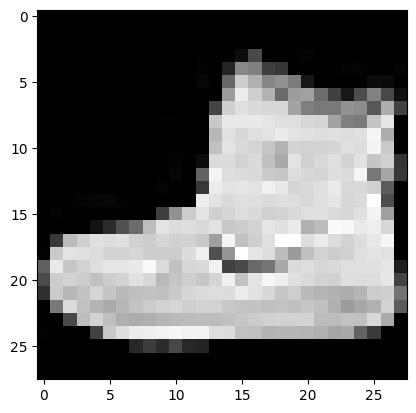

In [ ]:
plt.imshow(image.squeeze(),cmap = "gray")

In [ ]:
rand_image_tensor = torch.randn(size = (1,28,28))
rand_image_tensor

tensor([[[-7.9311e-02,  1.6144e+00, -4.6171e-01, -5.7414e-01,  5.1842e-01,
          -4.8354e-01,  1.3702e+00,  1.8823e-01, -6.3737e-01,  8.7616e-02,
           1.1489e+00,  8.7162e-01,  2.0577e-01, -1.0062e+00,  1.1125e+00,
          -7.4517e-01, -2.3947e-01,  7.5288e-01, -6.6769e-01,  5.5451e-01,
           9.0538e-01,  1.7207e+00,  3.2258e-01,  5.4998e-01,  1.3368e+00,
           9.1989e-01,  2.9305e-01,  7.0214e-01],
         [-1.0596e+00, -2.2214e+00,  7.0677e-01, -2.1389e-01, -1.0270e+00,
          -5.2316e-01,  1.4774e+00,  3.0483e-01, -6.4894e-01,  4.9036e-01,
          -2.8043e-01,  9.4100e-01, -8.9237e-01, -3.5752e-01,  1.0479e-01,
           4.1266e-02,  3.3505e-01, -2.4310e-01, -6.5055e-01, -3.3003e-01,
          -3.1443e-01, -1.3658e+00,  3.5626e-02, -4.3072e-01, -9.8891e-01,
          -1.0607e+00,  7.0623e-01, -2.2878e-01],
         [ 7.1535e-01,  4.1778e-01,  3.6404e-01, -1.6342e+00,  5.9972e-01,
          -3.3900e-01,  1.5490e-01, -2.7944e-01, -5.9674e-01,  2.4182e-02,


In [ ]:
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
model_2.state_dict()

OrderedDict([('block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
           

In [ ]:
torch.manual_seed(42)
images = torch.randn(size = (32,3,64,64))
test_image = images[0]
print(f"Image batch shape: {images.shape}\nTest image shape: {test_image.shape}")
print(f"Test image {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Test image shape: torch.Size([3, 64, 64])
Test image tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,  2.2465],
         [-1.3242, -0.1973,  0.2920,  ...,  0.5409,  0.6940,  1.8563]],

        [[-0.797

In [ ]:
# making a single conv2d test layer
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 3,
                       stride = 1,
                       padding = 0)
conv_output = conv_layer(test_image.unsqueeze(dim = 0))
conv_output.shape

torch.Size([1, 10, 62, 62])

In [ ]:
test_image.unsqueeze(dim = 0).shape
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [ ]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


In [ ]:
torch.manual_seed(42)
random_tensor  = torch.randn(size = (1,1,2,2))
max_pool_layer = nn.MaxPool2d(kernel_size = 2)
max_pool_tensor= max_pool_layer(random_tensor)
random_tensor,max_pool_tensor

(tensor([[[[0.3367, 0.1288],
           [0.2345, 0.2303]]]]),
 tensor([[[[0.3367]]]]))

#Training the Model


In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model_2.parameters(),lr = 0.1)

In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimiser=optimiser,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 2.30229| Train acc: 10.00
Test loss 2.30231| Test acc 9.99
Epoch: 1
---------
Train loss: 2.30228| Train acc: 10.00
Test loss 2.30231| Test acc 9.99
Epoch: 2
---------
Train loss: 2.30228| Train acc: 10.00
Test loss 2.30231| Test acc 9.99
Train time on cuda: 39.011 seconds


In [ ]:
model_2_results = eval_model(model = model_2,
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 2.3023061752319336,
 'model_acc': 9.994009584664537}

In [ ]:
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
import pandas as pd
compare_results = pd.DataFrame(data = [model_0_results,model_1_results,model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.494424,82.787540
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,2.302306,9.994010


In [ ]:
def make_predictions(model,
                     data,
                     device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample,dim = 0)
            pred_logit = model(sample.to(device))
            pred_prob = torch.softmax(pred_logit.squeeze(),dim = 0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)


In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample,label in random.sample(list(test_data),k = 9):
    test_samples.append(sample)
    test_labels.append(label)
test_samples[0].shape

torch.Size([1, 28, 28])

In [ ]:
pred_probs = make_predictions(model = model_1,
                            data = test_samples,
                            device = device)
pred_probs[:2]

tensor([[1.9443e-06, 1.9443e-06, 1.9443e-06, 1.9443e-06, 1.9443e-06, 9.1261e-01,
         1.9443e-06, 6.5332e-03, 3.0712e-06, 8.0840e-02],
        [1.0257e-01, 9.9714e-02, 9.9714e-02, 9.9714e-02, 9.9714e-02, 9.9714e-02,
         9.9714e-02, 9.9714e-02, 9.9714e-02, 9.9714e-02]])

In [ ]:
pred_classes = pred_probs.argmax(dim = 1)
pred_classes,test_labels

(tensor([5, 0, 7, 4, 0, 0, 4, 7, 1]), [5, 1, 7, 4, 3, 0, 4, 7, 1])

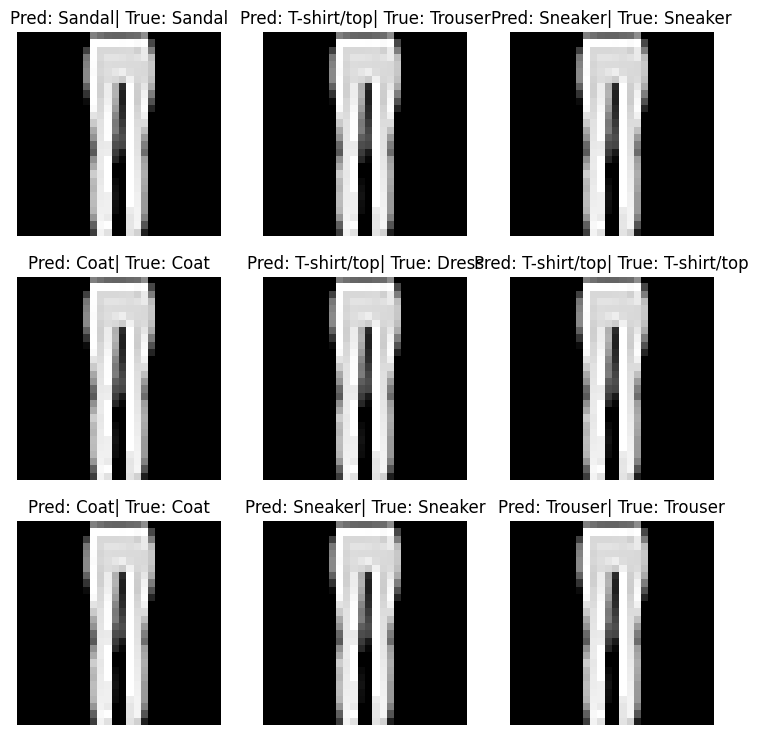

In [ ]:
plt.figure(figsize = (9,9))
for i,image in enumerate(test_samples):
    plt.subplot(3,3,i+1)
    plt.imshow(sample.squeeze(),cmap = "gray")
    pred_label = class_names[pred_classes[i]]
    true_label = class_names[test_labels[i]]
    plt.title(f"Pred: {pred_label}| True: {true_label}")
    plt.axis(False)